In [46]:
import numpy
import scipy
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import subprocess
import pandas as pd
import string
import pydotplus 
import pydot
import graphviz
#import pylab as plt
import matplotlib.pyplot as plt
from matplotlib import pyplot
from IPython.display import Image  
from sklearn import datasets
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import numpy.random as nprnd
import random
import json
%matplotlib inline

Please do one of the following.


# Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

2) Convert `default` and `student` to categorical variables.

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

8) Find the optimal decision tree depth and compute the AUC ROC. 

### Parts 1-3 :

In [47]:

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv ', index_col=0)
y1=df[['default']]
y2=df[['student']]
y3=df[['income']]
y4=df[['balance']]


df.head()


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


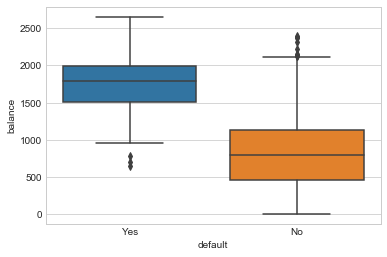

In [48]:
sns.set_style("whitegrid")
ax=sns.boxplot(x=df["default"],y=df["balance"],data=df,order=["Yes", "No"])


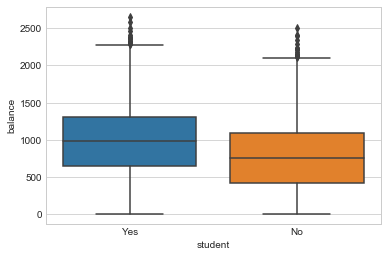

In [49]:
ax=sns.boxplot(x=df["student"],y=df["balance"],data=df,order=["Yes", "No"])

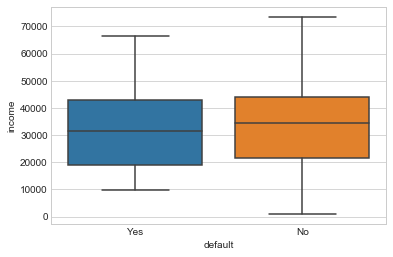

In [50]:
ax=sns.boxplot(x=df["default"],y=df["income"],data=df,order=["Yes", "No"])

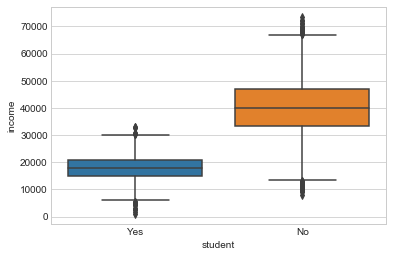

In [51]:
ax=sns.boxplot(x=df["student"],y=df["income"],data=df,order=["Yes", "No"])

In [52]:
# Convert default and student to categorical
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_balance=pd.get_dummies(df['balance'])
df_income=pd.get_dummies(df['income'])
df_updated = pd.concat([df_default,df_student],axis=1)
df_updated=df_updated.drop(['?'],1)


In [53]:
y1=df[['default']]
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


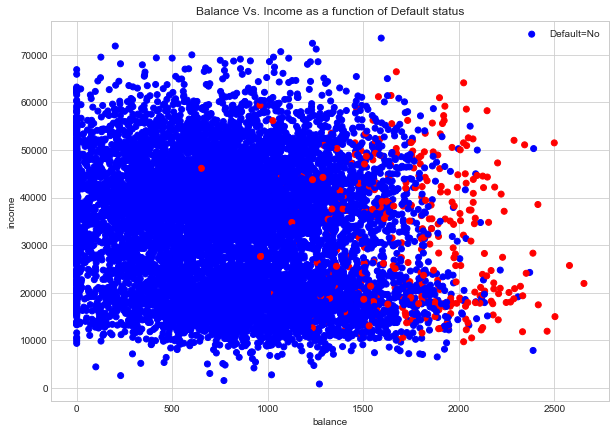

In [54]:
# (3 

y1=df[['default']]
default_color=[]
for i in range(0,len(y1)):
    if y1.iloc[i,0]=="Yes":
        default_color.append("red")
    else:
        default_color.append("blue")
      
    
plt.figure(figsize=(10,7))        
plt.scatter(df.balance,df.income, c=default_color,label = 'Default=No')
plt.title("Balance Vs. Income as a function of Default status")
plt.xlabel("balance")
plt.ylabel("income")
plt.legend()

plt.show()



### Part 4:

The optimal alpha is: 0.52983


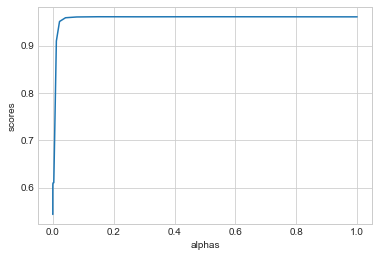

In [55]:

# Split the data into training/testing sets

y1 = df['default']  # convert y to binary!!
X1 = df[['balance','income']]     
X = numpy.asarray(X1)
y = numpy.zeros(len(y1))

for i in range(0,len(y1)):
    if y1.iloc[i]=="Yes":
        y[i]=0
    else:
        y[i]=1
        

        
        
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = numpy.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds        
    
    
# We Choose 80% for training, 20% for testing. 

# Method 1:
size =len(X)
y = numpy.asarray(y)


# Method 2 (this is better since it randomizes as well):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#choose optimal alpha


alphas = numpy.logspace(-8, 0, 30)#
train_errors=[]
test_errors=[]
coeffs=[]
scores=[]
for alpha in alphas:
    clf = LogisticRegression(penalty='l1', C=alpha)  # c = 1.0 default
    clf.fit(X_train,y_train)
    train_errors.append(clf.score(X_train,y_train))
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)
    coeffs.append(clf.coef_)
plt.plot(alphas,scores)
plt.xlabel('alphas')
plt.ylabel('scores')
test_errors=scores
alpha_optim=alphas[numpy.argmax(scores)]
alpha_best = alpha_optim


print('The optimal alpha is: %.5f' % alpha_best)





### Part 4 Continued: Decision Boundary and ROC

ROC AUC: 0.9608


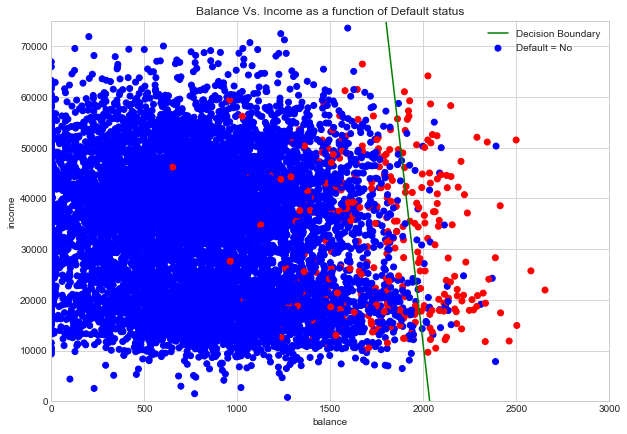

In [56]:
# Part 4 Decision boundary and ROC

clf = LogisticRegression(penalty='l1', C=alpha_best)  # c = 1.0 default
clf.fit(X_train,y_train)
coef = clf.coef_

y1=df[['default']]
default_color=[]
for i in range(0,len(y1)):
    
    if y1.iloc[i,0]=="Yes":
        default_color.append("red")
    else:
        default_color.append("blue")
ex1 = numpy.linspace(0, 3000, size)





fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha_best,penalty='l1')
print('ROC AUC: %.4f' % roc_auc)


#Decision boundary

ex2= (clf.intercept_ + clf.coef_[0,0]*ex1)/ -clf.coef_[0,1]  #+ regr.intercept_) 
plt.figure(figsize=(10,7))       
plt.scatter(df.balance,df.income, c=default_color,label = 'Default = No')
plt.plot(ex1,ex2,'g', label = 'Decision Boundary')
plt.title("Balance Vs. Income as a function of Default status")
plt.xlabel("balance")
plt.ylabel("income")
plt.xlim(0,3000)
plt.ylim(0, 75000)
plt.legend()

plt.show()

### Part 5

The optimal alpha is: 0.41753
ROC AUC: 0.96260


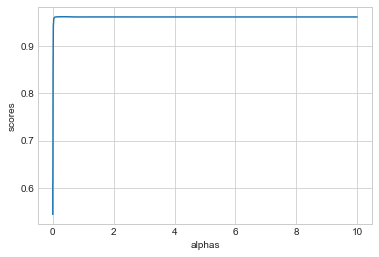

In [57]:
# 5) now 3 variables
y1=df[['default']]
z1 = df['student']


y = numpy.zeros(len(y1))

for i in range(0,len(y1)):
    if y1.iloc[i,0]=="Yes":
        y[i]=0
    if y1.iloc[i,0]=="No":
        y[i]=1
        
df_updated = pd.concat([df_student,df[['balance','income']] ],axis=1)   #now 3 variables
   
# We Choose 80% for training, 20% for testing. This should really be done randomly.
X = df_updated
# Method 1:
size =len(X)
y2 = numpy.asarray(y)


# Method 2 (this is better since it randomizes as well):
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)



#choose optimal alpha


alphas = numpy.logspace(-7, 1, 30)#
train_errors=[]
test_errors=[]
coeffs=[]
scores=[]
for alpha in alphas:
    clf = LogisticRegression(penalty='l1', C=alpha)  # c = 1.0 default
    clf.fit(X_train,y_train)
    train_errors.append(clf.score(X_train,y_train))
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y2,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)
    coeffs.append(clf.coef_)
plt.plot(alphas,scores)
plt.xlabel('alphas')
plt.ylabel('scores')
test_errors=scores
alpha_optim_final=alphas[numpy.argmax(scores)]
alpha_best = alpha_optim_final

print('The optimal alpha is: %.5f' % alpha_best)

clf = LogisticRegression(penalty='l1', C=alpha_best)  # c = 1.0 default
clf.fit(X_train,y_train)
coef=clf.coef_

fpr, tpr, roc_auc, thresholds= generate_auc(X,y2,LogisticRegression,C=alpha_best,penalty='l1')
print('ROC AUC: %.5f' % roc_auc)




## Part 5 Continued: Optimize with Ridge

The optimal alpha is: 0.0001000
ROC AUC: 0.6104938


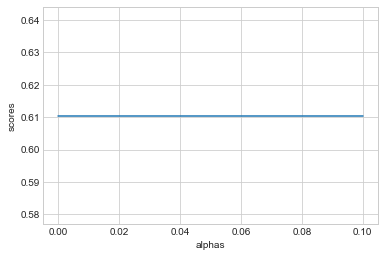

In [58]:
##### now with Ridge regression


alphas = numpy.logspace(-4, -1, 50)#

train_errors=[]
test_errors=[]
coeffs=[]
scores=[]
for alpha in alphas:
    clf = LogisticRegression(penalty='l2', C=alpha)  # c = 1.0 default ...now with RIDGE
    clf.fit(X_train,y_train)
    train_errors.append(clf.score(X_train,y_train))
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y2,LogisticRegression,C=alpha,penalty='l2')
    scores.append(roc_auc)
    coeffs.append(clf.coef_)
plt.plot(alphas,scores)
plt.xlabel('alphas')
plt.ylabel('scores')
test_errors=scores
alpha_optim=alphas[numpy.argmax(scores)]
alpha_best1 = alpha_optim

print('The optimal alpha is: %.7f' % alpha_best1)
clf = LogisticRegression(penalty='l2', C=alpha_best1)  # c = 1.0 default
clf.fit(X_train,y_train)
coef=clf.coef_

coef = numpy.zeros(4)

for i in range(0,len(coef)):
    coef[i]=clf.coef_[0,i]
    
        

fpr, tpr, roc_auc, thresholds= generate_auc(X,y2,LogisticRegression,C=alpha_best1,penalty='l2')
print('ROC AUC: %.7f' % roc_auc)



#### A plot of the coefficients:

<Container object of 4 artists>

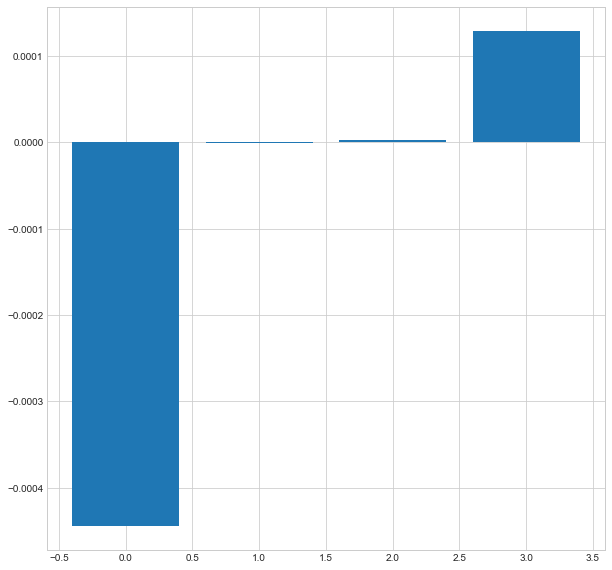

In [59]:
xx=numpy.linspace(0,3,4)
coef1=sorted(coef)
plt.figure(figsize=(10,10))
plt.bar(xx, coef1, align='center')

With the new variable added the Lasso ROC AUC improves.  The value increases from .9426 to .94383.  However Ridge regression lowers the ROC AUC to about .6

### PART 6

[0.9405679429584141, 0.9466428657146286, 0.9342425060761544, 0.9096070775092902, 0.9647423171603272]


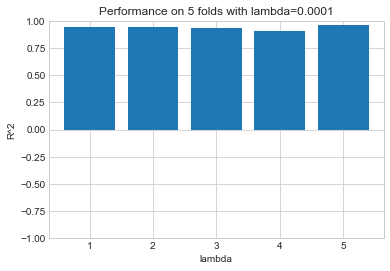

In [60]:
from sklearn.cross_validation import KFold
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    scores=[]
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        fpr, tpr, roc_auc, thresholds= generate_auc(X_train,y_train,LogisticRegression,C=alpha_best1,penalty='l2')
        y_pred[test_index] = clf.predict(X_test)
        scores.append(roc_auc)
    return scores


from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X2 = X.as_matrix().astype(numpy.float)
X2 = scaler.fit_transform(X)

scores=run_cv_coeffs(X2,y2,Ridge,alpha=alpha_best1)

print (scores)
plt.ylim([-1,1])
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 5 folds with lambda=' + str(alpha_best1))
plt.bar(range(1,6),scores)
plt.show()


[0.9429738183503243, 0.9694609551137529, 0.9690635451505017]


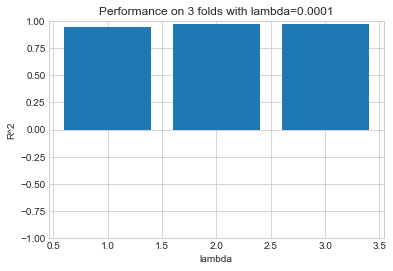

In [61]:
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=3,shuffle=True)
    y_pred = y.copy()
    scores=[]
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        fpr, tpr, roc_auc, thresholds= generate_auc(X_train,y_train,LogisticRegression,C=alpha_best1,penalty='l2')
        y_pred[test_index] = clf.predict(X_test)
        scores.append(roc_auc)
    return scores


from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X2 = X.as_matrix().astype(numpy.float)
X2 = scaler.fit_transform(X)

scores=run_cv_coeffs(X2,y2,Ridge,alpha=alpha_best1)

print (scores)
plt.ylim([-1,1])
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 3 folds with lambda=' + str(alpha_best1))
plt.bar(range(1,4),scores)
plt.show()


[0.9444991840379345, 0.9415534905885156, 0.9303390872018322, 0.936483288967761, 0.9382678806494076, 0.9440109184328838, 0.9687122857832489]


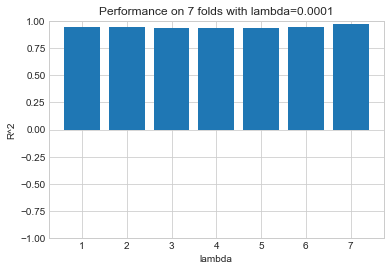

In [62]:
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=7,shuffle=True)
    y_pred = y.copy()
    scores=[]
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        fpr, tpr, roc_auc, thresholds= generate_auc(X_train,y_train,LogisticRegression,C=alpha_best1,penalty='l2')
        y_pred[test_index] = clf.predict(X_test)
        scores.append(roc_auc)
    return scores


from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X2 = X.as_matrix().astype(numpy.float)
X2 = scaler.fit_transform(X)

scores=run_cv_coeffs(X2,y2,Ridge,alpha=alpha_best1)

print (scores)
plt.ylim([-1,1])
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 7 folds with lambda=' + str(alpha_best1))
plt.bar(range(1,8),scores)
plt.show()


### Part 7: Decision Tree Classifier

R^2 Score is: 0.6379239


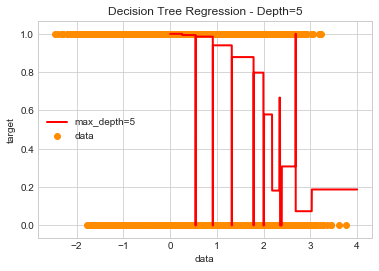

In [63]:
regr_5= DecisionTreeRegressor(max_depth=5)
regr_5.fit(X2, y2)
X_test1 = numpy.linspace(0.0, 4.0, len(X2))[:, numpy.newaxis]
a=numpy.concatenate((X_test1, X_test1,X_test1,X_test1), axis=1)
y_0 = regr_5.predict(a)
fpr, tpr, roc_auc, thresholds= generate_auc(X2,y2,DecisionTreeClassifier)
score1=roc_auc
print('R^2 Score is: %.7f' % score1)
plt.scatter(X2[:,0], y2, c="darkorange",label="data")
plt.scatter(X2[:,1], y2, c="darkorange")
plt.scatter(X2[:,2], y2, c="darkorange")
plt.scatter(X2[:,3], y2, c="darkorange")
plt.plot(a[:,0], y_0, color="red", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression - Depth=5")
plt.legend()
plt.show()


The score for the decision tree classifier is low of .65 so the logistic regression classifier has better performance.

In [64]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr_5, feature_names=['x'])

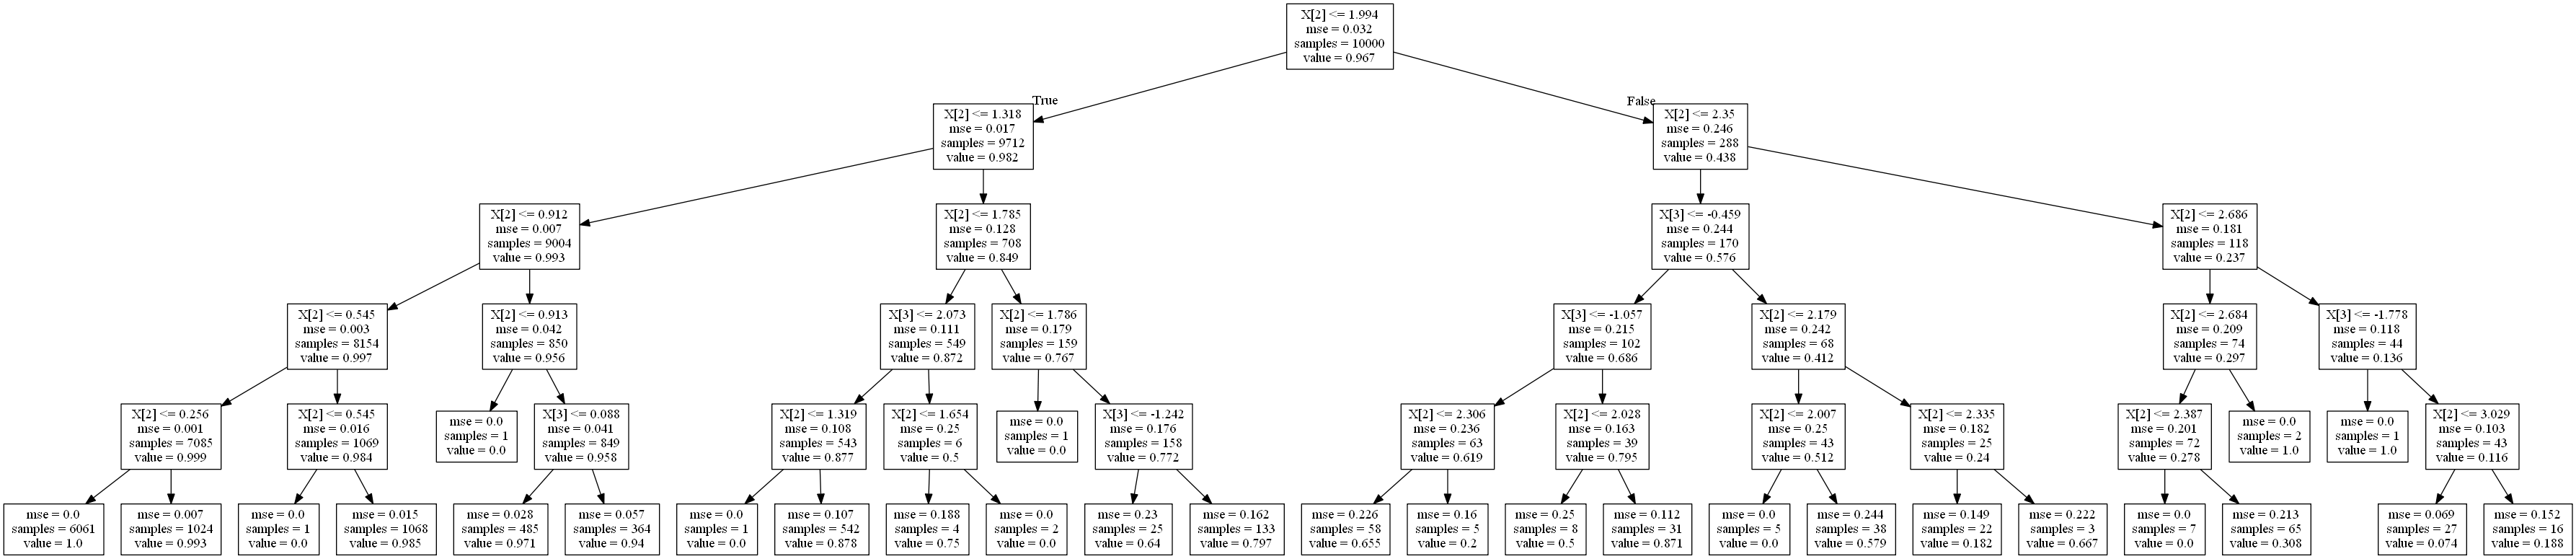

In [65]:
from IPython import display
from IPython.display import Image  
dot_data=export_graphviz(regr_5, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 


### Part 8

13


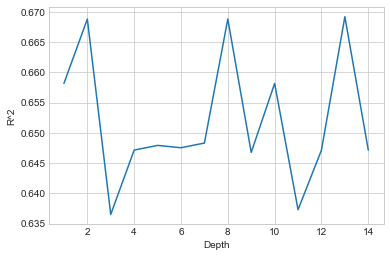

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)


scores=[]
depths = range(1,15)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    fpr, tpr, roc_auc, thresholds= generate_auc(X_train,y_train,DecisionTreeClassifier)
    scores.append(roc_auc)
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[numpy.argmax(scores)]

print (n_opt)

R^2 Score is: 0.7825416
Max depth is: 13.0


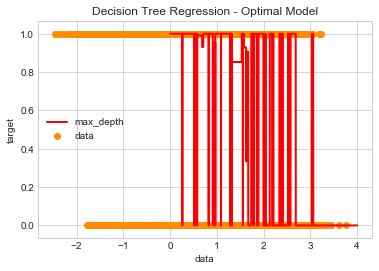

In [70]:
regr_opt = DecisionTreeRegressor(max_depth=n_opt)
regr_opt.fit(X2, y2)
X_test1 = numpy.linspace(0.0, 4.0, len(X2))[:, numpy.newaxis]
a=numpy.concatenate((X_test1, X_test1,X_test1,X_test1), axis=1)
y_0 = regr_opt.predict(a)

score1=regr_opt.score(X2, y2)

print('R^2 Score is: %.7f' % score1)
print('Max depth is: %.1f' % n_opt)
plt.scatter(X2[:,0], y2, c="darkorange",label="data")
plt.scatter(X2[:,1], y2, c="darkorange")
plt.scatter(X2[:,2], y2, c="darkorange")
plt.scatter(X2[:,3], y2, c="darkorange")
plt.plot(a[:,0], y_0, color="red", label="max_depth", linewidth=2)

plt.xlabel("data")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression - Optimal Model")
plt.legend()
plt.show()

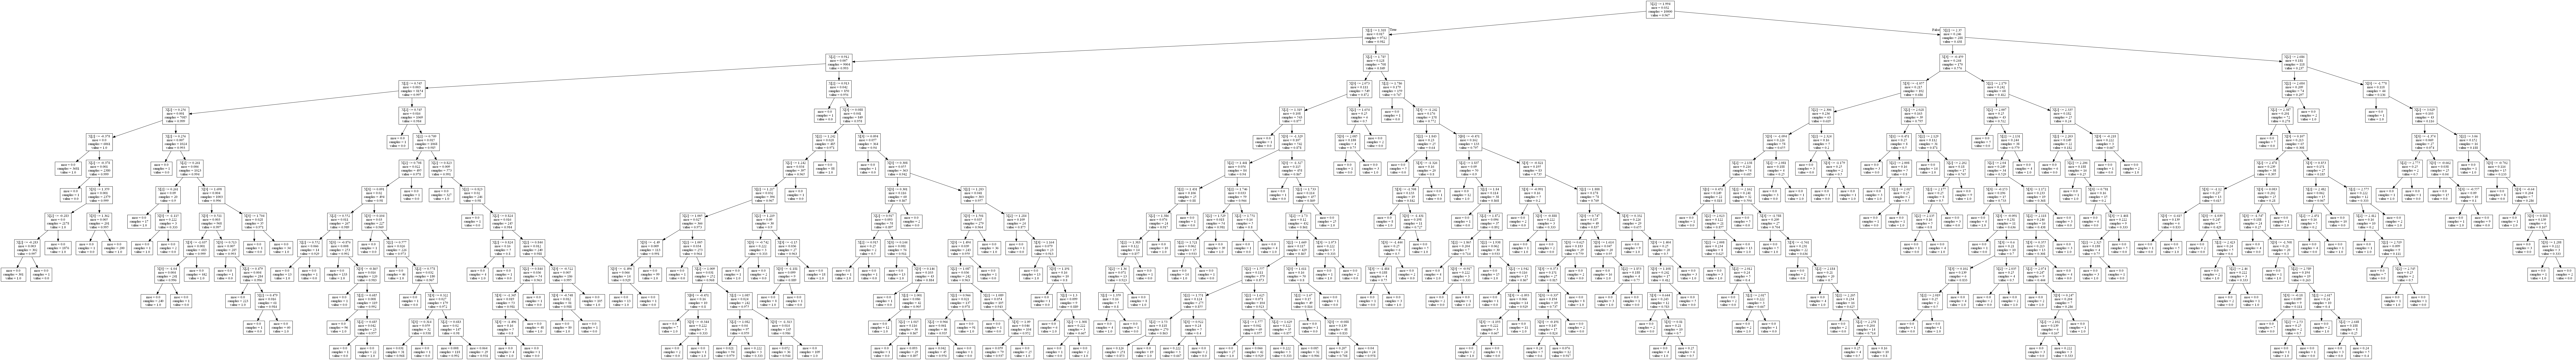

In [71]:
dot_data=export_graphviz(regr_opt, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 